This notebook involves the intersection of authors and members of the Shakespeare and Company lending library.

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn2

Here, the `books` and `members` datasets from Princeton University's Shakespeare and Company Project are loaded. The `books` dataset contains information about the books in the library of Shakespeare and Company. The `members` dataset contains information about the members of the library.

In [57]:
books = pd.read_csv('../data/raw/SCoData_books_v1.2_2022_01.csv',
                    encoding='utf-8',
                    dtype={'year': 'Int32'})

members = pd.read_csv(
    '../data/raw/SCoData_members_v1.2_2022_01.csv',
    encoding='utf-8',
    dtype={'birth_year': 'Int32', 'death_year': 'Int32'}
)

In [58]:
print(books.columns)

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')


In [59]:
print(members.columns)

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')


## Authors

In the next steps, the authors will be identified. The authors are the people who wrote the books that are in the Shakespeare and Company lending library. The authors are identified by the `author` field in the `books` DataFrame.

In [60]:
# Filter books of format 'Book', select the 'author' column, drop missing values and duplicates
filtered_authors = (
    books.loc[books['format'] == 'Book', ['author']]
    .dropna(subset=['author'])
    .drop_duplicates(subset=['author'])
)

# Retain only rows with a single author by excluding entries that contain a semicolon
unique_authors = filtered_authors[
    ~filtered_authors['author'].str.contains(';')
].reset_index(drop=True)

# Output the shape and content of the resulting DataFrame
print(unique_authors.shape)
print(unique_authors.tail(5))

(1883, 1)
                author
1878  Hakluyt, Richard
1879       Kyd, Thomas
1880       Polo, Marco
1881     Nashe, Thomas
1882   Myers, F. W. H.


## Members

In the next step, the members will be identified. The members are the people who were registered at the Shakespeare and Company lending library. The members are identified by the `sort_name` field in the `members` DataFrame.

In [61]:
# Select the 'sort_name' column, filter out missing values, and remove duplicate entries
unique_members = (
    members.loc[members['sort_name']
    .notna(), ['sort_name']]
    .drop_duplicates()
)

# Output the shape of the resulting DataFrame
print(unique_members.shape)

(4804, 1)


## Intersection: Authors and Members

Now the intersection between authors and members will be identified to extract the authors who were also members of the Shakespeare and Company lending library. The intersection is identified by the `author` field in the `books` DataFrame and the `sort_name` field in the `members` DataFrame.

In [62]:
# Compute the intersection between unique authors and unique members using pandas Index
intersection_names = pd.Index(unique_authors['author']).intersection(unique_members['sort_name'])

# Filter the members DataFrame to retain only those entries whose 'sort_name' is in the intersection
member_is_author = members[members['sort_name'].isin(intersection_names)]

member_is_author = member_is_author.reset_index(drop=True)

# Output debugging/verification information
print(f"Intersection count: {len(intersection_names)}")
print(f"Matched members shape: {member_is_author.shape}")

Intersection count: 84
Matched members shape: (84, 19)


The `member_is_author` DataFrame contains the authors who were also members of the Shakespeare and Company lending library. It has the following columns:

In [63]:
print(member_is_author.columns)

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')


Now saving the `member_is_author` data to a csv file.

In [64]:
# Export the DataFrame to CSV
member_is_author.to_csv(
    '../data/processed/table-data/01_member_is_author.csv',
    index=False,
    encoding='utf-8'
)

Now saving the `names` in the `member_is_author` data to a txt file.

In [65]:
# Remove any leading or trailing whitespace from each name
member_is_author_names = member_is_author['name']

print(member_is_author_names.head(10))

# Open the target file and write each name on a new line.
with open('../data/processed/table-data/01_member_is_author_names.txt', 'w', encoding='utf-8') as f:
    for name in member_is_author_names:
        f.write(name + '\n')

0          Richard Aldington
1       Margaret C. Anderson
2             George Antheil
3               Louis Aragon
4                Nathan Asch
5               Djuna Barnes
6    Natalie Clifford Barney
7               Joseph Beach
8               Sylvia Beach
9             Samuel Beckett
Name: name, dtype: object


The next step is to create a Venn diagram to visualize the intersection between authors and members, and to identify the authors who were also members of the Shakespeare and Company lending library.

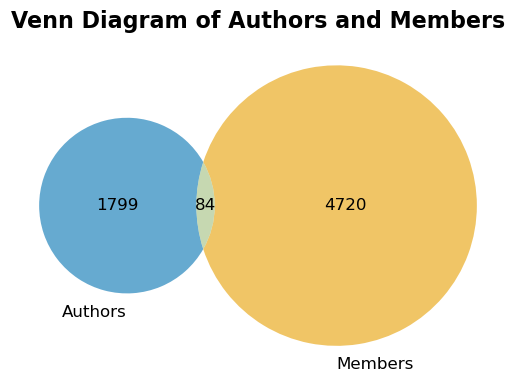

In [66]:
# Calculate the number of elements exclusive to each set and the intersection
authors_only = len(unique_authors) - len(intersection_names)
members_only = len(unique_members) - len(intersection_names)
common = len(intersection_names)

# Create the Venn diagram with customized colors and transparency
venn_diagram = venn2(subsets=(authors_only, members_only, common),
                     set_labels=('Authors', 'Members'),
                     set_colors=('#0072B2', '#E69F00'),
                     alpha=0.6)

# Customize the subset labels by setting font size and color
for subset_label in venn_diagram.subset_labels:
    if subset_label is not None:
        subset_label.set_fontsize(12)
        subset_label.set_color('black')

# Set the title of the diagram
plt.title("Venn Diagram of Authors and Members", fontsize=16, fontweight='bold')

# Save the figure
plt.savefig('../data/processed/figure-images/01_venn_diagram.png', dpi=300)

# Display the final Venn diagram
plt.show()

The following calculates the intersection relative to the number of authors and members, respectively.

In [67]:
# Calculate the size of the intersection set
intersection_size = len(intersection_names)

# Calculate the percentages
percent_intersection_authors = (intersection_size / len(unique_authors)) * 100
percent_intersection_members = (intersection_size / len(unique_members)) * 100

# Print the results
print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.46%
Percent of the intersection relative to members: 1.75%
